In [1]:
import sys

# adding Folder_2 to the system path
#sys.path.insert(0, '/Users/lisadang/Desktop/Github/SPCA')

# path to astro_models
sys.path.insert(0, '/Users/alexandrarochon/Programming/LHS1140-Eureka/myAnalysis')
import astro_models
import numpy as np
import matplotlib.pyplot as plt
import pickle, os
import batman
import emcee
import astropy
from astropy.time import Time
import h5py
import corner
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from multiprocessing import Pool
import matplotlib.ticker as mticker
from mc3.stats import time_avg
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support
import matplotlib.patches as patches
from scipy.optimize import curve_fit


In [2]:
eclipse = ['3']
aperture = ['5']
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004']

# Initialize dictionaries to hold arrays for each aperture
time_arr = {a: [] for a in aperture}
aplev_arr = {a: [] for a in aperture}
aperr_arr = {a: [] for a in aperture}
centroid_x_arr = {a: [] for a in aperture}
centroid_y_arr = {a: [] for a in aperture}

for a in aperture:
    for seg in segments:
        if eclipse[0] == '1':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse[0]+'/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif eclipse[0] == '2':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse[0]+'/Stage3/S3_2024-07-22_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        elif eclipse[0] == '3':
            path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+eclipse[0]+'/Stage3/S3_2024-08-05_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time_arr[a] = np.append(time_arr[a], np.array(file['time']))
            aplev_arr[a] = np.append(aplev_arr[a], np.array(file['aplev']))
            aperr_arr[a] = np.append(aperr_arr[a], np.array(file['aperr']))
            centroid_x_arr[a] = np.append(centroid_x_arr[a], np.array(file['centroid_x']))
            centroid_y_arr[a] = np.append(centroid_y_arr[a], np.array(file['centroid_y']))

    time_arr[a] = np.array(time_arr[a])
    aplev_arr[a] = np.array(aplev_arr[a])
    aperr_arr[a] = np.array(aperr_arr[a])
    centroid_x_arr[a] = np.array(centroid_x_arr[a])
    centroid_y_arr[a] = np.array(centroid_y_arr[a])
    
print(time_arr['5'])

[60275.77646891 60275.77659717 60275.77672543 ... 60275.93794689
 60275.93807515 60275.93820341]


Text(0, 0.5, 'Normalized Flux')

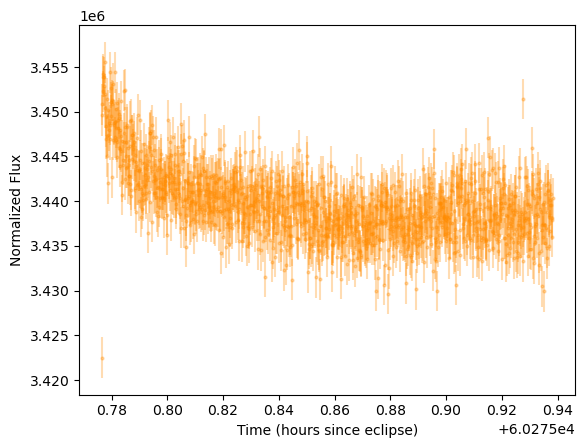

In [5]:
plt.errorbar(time_arr['5'], aplev_arr['5'], yerr=aperr_arr['5'], color='darkorange',markersize=2, alpha=0.3, fmt='o')
#plt.errorbar(time, aplev, yerr=aperr, color='blue',markersize=2, alpha=0.3, fmt='o')
plt.xlabel('Time (hours since eclipse)')
plt.ylabel('Normalized Flux')

In [155]:
# remove the first 2 points, rename arrays, normalize and set t_s = 0
ndiscard = 2
time = time_arr['5'][ndiscard:]
aplev = aplev_arr['5'][ndiscard:]
aperr = aperr_arr['5'][ndiscard:]
centroid_x = centroid_x_arr['5'][ndiscard:]
centroid_y = centroid_y_arr['5'][ndiscard:]

# set up parameters and set t_s = 0
eclipse = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
eclipse = eclipse.mjd
eclipse = (eclipse-time[0])*24
print(eclipse)
e_dur = 1.13 # hours
e_dur_days = e_dur / 24
#transit = Time('2458389.293900', format = 'jd', scale = 'tdb')

# set up parameters for the MCMC
model_type = 'exp' # 'exp+linear' or 'exp'

t_s = (60275.875-time[0])*(24)
fp = 0.000230
p0_astro = np.array([t_s, fp]) 
time = (time - time[0])*(24)
#print(t_s)
if model_type == 'exp+linear':
    # first guess from scipy curve_fit on the data
    p0_detec = np.array([0.00344908196627231, 2.1384616526923503, 0.9996595799196581, -0.0010410549754198636, 63.750405971837964])
elif model_type == 'exp':
    p0_detec = np.array([0.00344908196627231, 2.1384616526923503, 0.9996595799196581])

aperr = aperr / np.mean(aplev)
aplev = aplev / np.mean(aplev)


2.358589777140878
2.358589777140878


In [218]:
def transit_model(time, t_s, fp):
    params = batman.TransitParams()       #object to store transit parameters
    #params.t0 = (58388.7939-eclipse)/24                #time of inferior conjunction
    #params.t0 = 58388.7939
    #params.t0 = (58388.7939-time[0])/24
    params.t0 = 58388.7939*24
    params.per = 3.777940*24                 #orbital period in hours
    params.rp = 0.0539                   #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux

def exponential_func(x, a, b, c):
    #x = (x - x[0])*24
    return a * np.exp(-b * x) + c

def linear_slope(time, m, b):
    return m*time + b

def detec_model(time, theta, model_type):
    detec = []
    if model_type == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta
        detec = exponential_func(time, c1, c2, c3, c4)*linear_slope(time, c5, c6)
    elif model_type == 'exp':
        t_s, fp, c1, c2, c3, sigF = theta
        detec = exponential_func(time, c1, c2, c3)
    return detec

def signal(time, theta, model_type):
    if model_type == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta
    elif model_type == 'exp':
        t_s, fp, c1, c2, c3, sigF = theta
    astro = transit_model(time, t_s, fp)
    detec = detec_model(time, theta, model_type)
    # should this be + or *?
    return astro*detec


In [219]:
def log_likelihood(theta, time, flux, model_type):
    
    model = signal(time, theta, model_type)
    sigF = theta[-1]
    sigma2 = sigF**2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta, model_type):
    if model_type == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta
    elif model_type == 'exp':
        t_s, fp, c1, c2, c3, sigF = theta

    # gaussian prior
    prior = 0.
    #prior -= 0.5 * (((t_s - 60275.875) / 0.000040) ** 2.)

    # uniform prior
    # 

    if model_type == 'exp+linear':
        if (0 < fp < 1 and (eclipse-(e_dur_days/2)) < t_s < (eclipse+(e_dur_days/2)) and sigF > 0. ): 
            return 0.0 + prior
        return np.inf
    elif model_type == 'exp':
        if (0 < fp < 1 and (eclipse-(e_dur/2)) < t_s < (eclipse+(e_dur/2)) and 0.00344908196627231*0.95 < c1 < 0.00344908196627231*1.05 and 2.1384616526923503*0.95 < c2 < 2.1384616526923503*1.05 and  0.9996595799196581*0.95 < c3 <  0.9996595799196581*1.05 and sigF > 0.): 
            return 0.0 + prior
        return -np.inf

def log_prob(theta, time, flux, model_type):
    lp = log_prior(theta, model_type)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, model_type)

In [220]:
p0 = np.concatenate((p0_astro, p0_detec, [0.001]))
nsteps, nwalkers, ndim = 10000, 70, len(p0)

# lower the initial position scatter
pos = p0 + 1e-5 * np.random.randn(nwalkers, ndim)

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, aplev, centroid_x, centroid_y)) 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time, aplev, model_type))
#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(bins_time, bins_aplev/exponential_func(bins_time, a, b, c), centroid_x, centroid_y))
pos2, prob, state = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 10000/10000 [01:17<00:00, 129.16it/s]


In [221]:
nBurnInSteps2 = 1000
lnprobchain = sampler.get_log_prob(discard=nBurnInSteps2).swapaxes(0,1)
chain = sampler.get_chain(discard=nBurnInSteps2).swapaxes(0,1)

# Save the chains
ecl = '1'
savepath = 'MCMC_results/ecl'+ecl+'_'+model_type+'_test_'
pathchain = savepath + 'samplerchain_10000.npy'
pathlnlchain = savepath + 'samplerlnlchain_10000.npy'
pathposit = savepath + 'samplerposi_10000.npy'
pathlnpro = savepath + 'samplerlnpr_10000.npy'
np.save(pathchain, chain)
np.save(pathlnlchain, lnprobchain)
np.save(pathposit, pos2)
np.save(pathlnpro, prob)

In [222]:
# Load previous MCMC results to make compare plot
#models = ['exp+linear']
models = ['exp']
ecl = '1'
chain = {model: [] for model in models}
lnprobchain = {model: [] for model in models}
pos2 = {model: [] for model in models}
prob = {model: [] for model in models}
p0_mcmc = {model: [] for model in models}

for model in models:
    savepath = 'MCMC_results/ecl'+ecl+'_'+model+'_'
    pathchain = savepath+'samplerchain_10000.npy'
    pathlnlchain = savepath+'samplerlnlchain_10000.npy'
    pathposit = savepath+'samplerposi_10000.npy'
    pathlnpro = savepath+'samplerlnpr_10000.npy'
    chain[model] = np.load(pathchain)
    lnprobchain[model] = np.load(pathlnlchain)
    pos2[model] = np.load(pathposit)
    prob[model] = np.load(pathlnpro)
    maxk, maxiter = np.unravel_index((lnprobchain[model]).argmax(), (lnprobchain[model]).shape)   
    p0_mcmc[model] = chain[model][maxk, maxiter,:] 

In [223]:
#model = 'exp'
ndim = len(p0)
samples = chain[model].reshape((-1, ndim))

MCMC_Results = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))

maxk, maxiter = np.unravel_index((lnprobchain[model]).argmax(), (lnprobchain[model]).shape)
p0_mcmc[model] = chain[model][maxk, maxiter,:]
for i in range(len(p0_mcmc[model])):
    MCMC_Results[i] = (p0_mcmc[model][i], MCMC_Results[i][1], MCMC_Results[i][2])

p0_labels = ['t_s','fp', 'c_1', 'c_2', 'c_3', 'sigF']

out = "MCMC result:\n\n"
for i in range(len(p0_mcmc[model])):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])
print(out, flush=True)

MCMC result:

     t_s = 2.3574540733144156  +0.04519281045902179  -0.05262024892998074
      fp = 0.00033154955372491037  +5.439381540979857e-05  -5.4120889332658355e-05
     c_1 = 0.0034969910798945828  +9.306689761585246e-05  -9.781909069867586e-05
     c_2 = 2.200738718327359  +0.06894670560526617  -0.06942145946600853
     c_3 = 0.9993481256573673  +4.388164345814349e-05  -4.3843636462037594e-05
    sigF = 0.0008113772139488521  +1.6438795453056418e-05  -1.590708613487897e-05



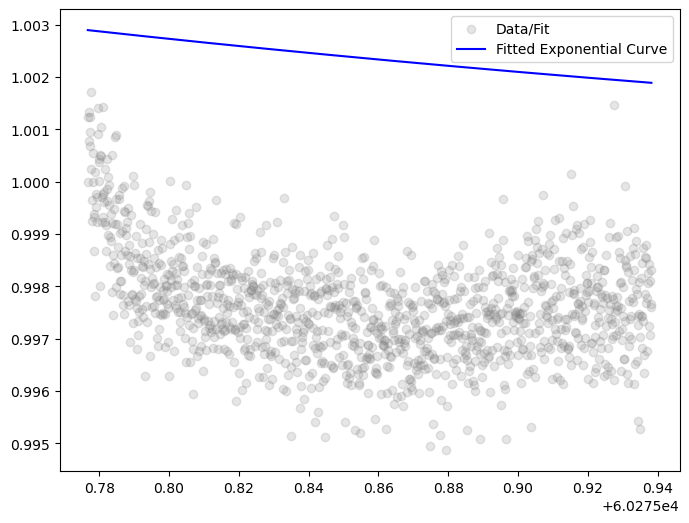

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter(time, aplev/fit_y, marker='o', label='Data/Fit', color='grey', alpha=0.2)

#plt.errorbar(time, aplev, yerr=aperr, fmt='o', label='Data', color='black')
plt.plot(time, fit_y, label='Fitted Exponential Curve', color='blue')
plt.legend()

## remove d as a fit param

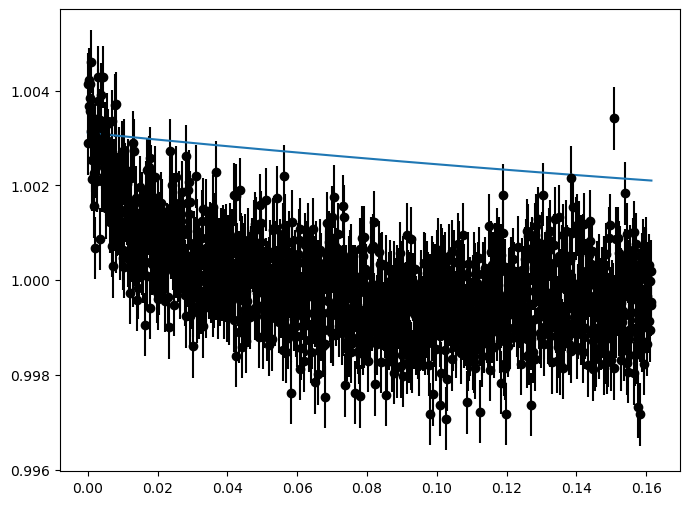

In [81]:
# 0.00344908196627231 2.1384616526923503 0.9996595799196581
# def exponential_func(x, a, b, c):
#     x = x - x[0]
#     return a * np.exp(-b * x) + c
nbin = 100
bins_time, binErr_t = binValues(time, time, nbin)
bins_aplev, binErr_aplev = binValues(aplev, time, nbin)
bins_time = (bins_time - bins_time[0])*24    
times = (time - time[0])*24
def exponential_func(x, a, b, c):

    return a * np.exp(-b * x) + c

a =0.00344908196627231 
b= 2.1384616526923503 
c=0.9996595799196581

plt.figure(figsize=(8, 6))
fit_y = exponential_func(bins_time, a, b, c)
fits = exponential_func((time-time[0]), a, b, c)
plt.errorbar((time-time[0]), aplev, yerr=aperr, fmt='o', label='Data', color='black')
plt.plot((time-time[0]), fits)
#plt.plot(bins_time,fit_y)

# plt.ylim(0.998, 1.004)
# plt.xlim(0,0.175)

# only works in hours

0.00344908196627231 2.1384616526923503 0.9996595799196581


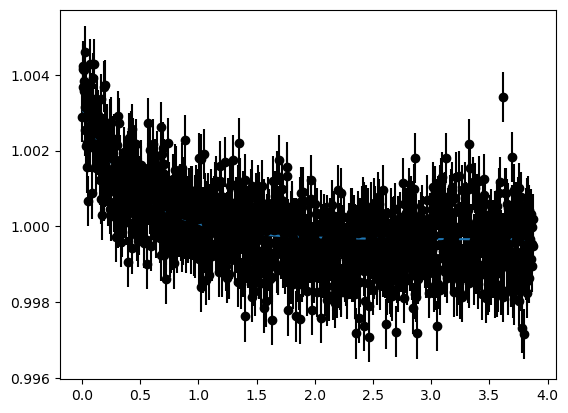

In [132]:
#params, covariance = curve_fit(exponential_func, (time-time[0])*24, aplev)

# Extract the fitting parameters
# a, b, c = params
# print(a,b,c)
print(a,b,c) #0.0035635276702469126 1.9243782897904247 0.9995214174823638
# 0.00344908196627231 2.1384616526923503 0.9996595799196581
a = 0.00344908196627231
b = 2.1384616526923503
c = 0.9996595799196581

def exponential_func(x, a, b, c):

    return a * np.exp(-b * x) + c

times = time_arr['5'][2:]
times = (times - times[0])*24

fits = exponential_func(times, a, b, c)
#plt.plot((times-times[0])*24, aplev, label='Data', color='black', alpha=0.1, marker='o')
plt.errorbar(times, aplev, yerr=aperr, fmt='o', label='Data', color='black')
plt.plot(times, fits)

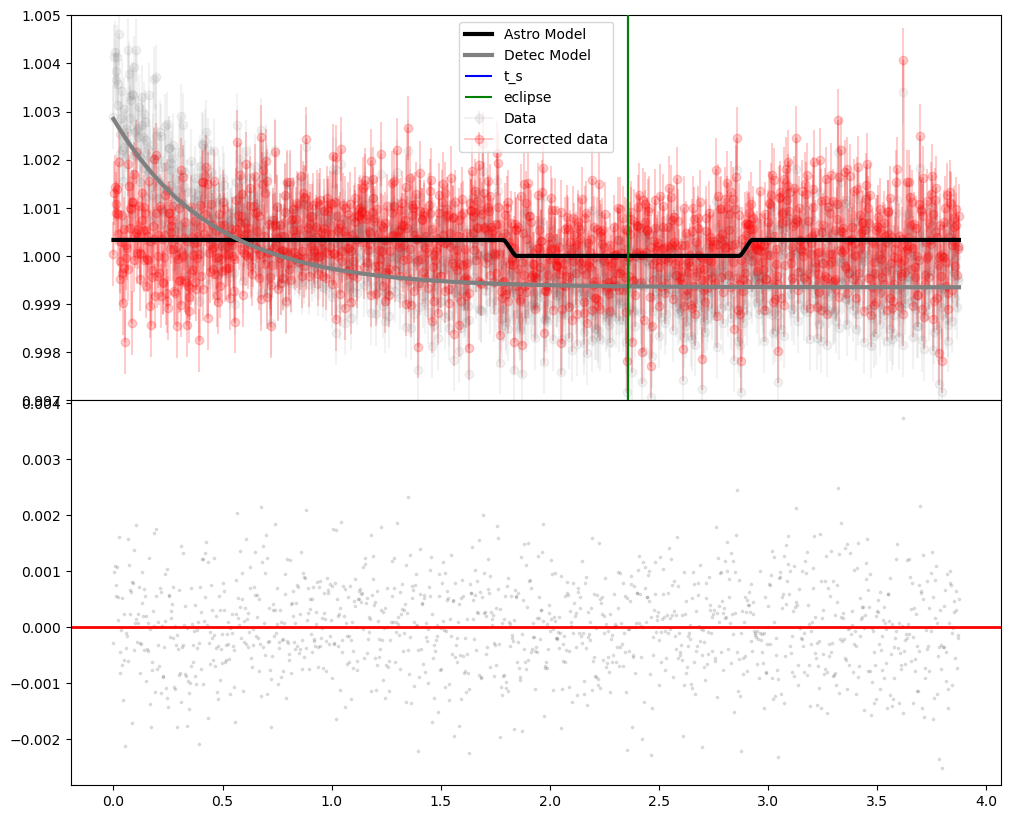

In [224]:
t_s, fp, c1, c2, c3, sigF = p0_mcmc[model]
astro = transit_model(time, t_s, fp)
detec = detec_model(time, [t_s, fp, c1, c2, c3, sigF], model)
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].errorbar(time, aplev, yerr =aperr, label='Data', color='grey', alpha=0.1, marker='o', zorder=1)
ax[0].errorbar(time,aplev/detec, yerr =aperr, label='Corrected data', color='red', alpha=0.2, marker='o', zorder=1)
ax[0].plot(time, astro, label='Astro Model',color = 'black', zorder=2, linewidth=3)
ax[0].plot(time, detec, label='Detec Model', color = 'grey', zorder=2, linewidth=3)
ax[0].vlines(t_s, 0.994, 1.008, color='blue', label='t_s', zorder=3)
ax[0].vlines(eclipse, 0.994, 1.008, color='green', label='eclipse', zorder=3)
ax[0].set_ylim(0.997, 1.005)
ax[0].legend()
residuals = (aplev/detec)-astro
ax[1].scatter(time,residuals, label='Residuals', color='black', alpha=0.1, marker='o', s=3)
ax[1].axhline(y=0, color='r', linewidth = 2)

# no h space
plt.subplots_adjust(hspace=0)
# plt.xlabel('Time (hours since begining of observations)')
# plt.ylabel('Normalized Flux')

In [334]:
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    """Bin values and compute their binned noise.

    Args:
        values (ndarray): An array of values to bin.
        binAxisValues (ndarray): Values of the axis along which binning will occur.
        nbin (int): The number of bins desired.
        assumeWhiteNoise (bool, optional): Divide binned noise by sqrt(nbinned) (True) or not (False, default).

    Returns:
        tuple: binned (ndarray; the binned values),
            binnedErr (ndarray; the binned errors)
    
    """
    
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

nbin = 100
print(len(time))
bins_time, binErr_t = binValues(time, time, nbin)


1260


In [335]:
# retrieve proper errorbars on aplev
def binValues(values, error, binAxisValues, nbin, assumeWhiteNoise=True):
    """Bin values and compute their binned noise.

    Args:
        values (ndarray): An array of values to bin.
        binAxisValues (ndarray): Values of the axis along which binning will occur.
        nbin (int): The number of bins desired.
        assumeWhiteNoise (bool, optional): Divide binned noise by sqrt(nbinned) (True) or not (False, default).

    Returns:
        tuple: binned (ndarray; the binned values),
            binnedErr (ndarray; the binned errors)
    
    """
    
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binCounts = np.array([np.sum(digitized == i) for i in range(1, nbin)])

    binnedErr = np.array([np.mean(error[digitized == i]) for i in range(1, nbin)])/np.sqrt(binCounts)
    #binnedErr = np.array([np.sqrt(np.sum((error[digitized == i])**2))/(binCounts)  for i in range(1, nbin)]) 
    #binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))

    return binned, binnedErr

bins_aplev, binErr_aplev = binValues(aplev, aperr, time, nbin)


In [360]:
t_s, fp, c1, c2, c3, sigF = p0_mcmc[model]
print(t_s, fp, c1, c2, c3, sigF)

2.3574540733144156 0.00033154955372491037 0.0034969910798945828 2.200738718327359 0.9993481256573673 0.0008113772139488521


Text(0, 0.5, 'Normalized Flux')

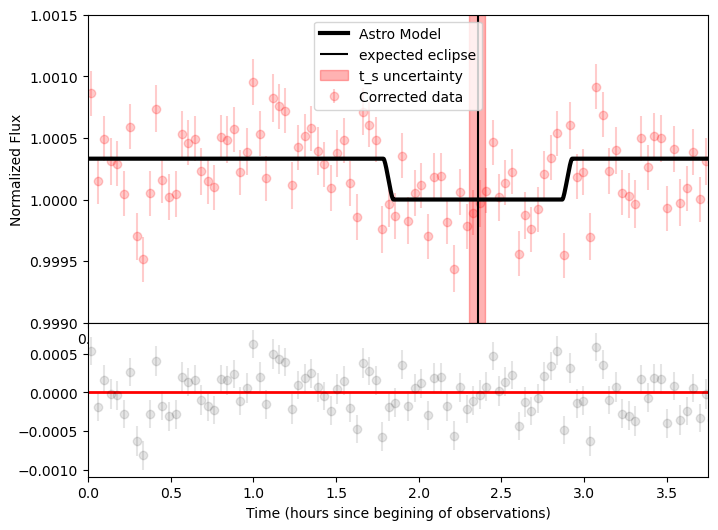

In [359]:
t_s, fp, c1, c2, c3, sigF = p0_mcmc[model]
astro = transit_model(bins_time, t_s, fp)
detec = detec_model(bins_time, [t_s, fp, c1, c2, c3, sigF], model)
fig, ax = plt.subplots(2, 1, figsize=(8, 6),  gridspec_kw={'height_ratios': [2, 1]})
# adjust height of second plot


#ax[0].errorbar(bins_time, bins_aplev, yerr=bins_aperr, label='Data', color='grey', alpha=0.1, marker='o', zorder=1)
ax[0].errorbar(bins_time,bins_aplev/detec, yerr=binErr_aplev, label='Corrected data', color='red', linestyle='none', alpha=0.2, marker='o', zorder=1)
ax[0].plot(time, transit_model(time, t_s, fp), label='Astro Model',color = 'black', zorder=2, linewidth=3)
#ax[0].plot(bins_time, detec, label='Detec Model', color = 'grey', zorder=2, linewidth=3)
#ax[0].vlines(t_s, 0.994, 1.008, color='blue', label='t_s', zorder=3)
ax[0].vlines(eclipse, 0.994, 1.008, color='black', label='expected eclipse', zorder=3)
#ax[0].vlines(t_s-5.4120889332658355e-05, t_s+5.439381540979857e-05,   color='blue') # rajouter la std shaded
ax[0].axvspan(t_s-0.05262024892998074, t_s+0.04519281045902179, color='red', alpha=0.3, label = 't_s uncertainty')
ax[0].set_ylim(0.999, 1.0015)
ax[0].set_xlim(0,3.75)
ax[1].set_xlim(0,3.75)
ax[0].legend()
residuals = (bins_aplev/detec)-astro
ax[1].errorbar(bins_time,residuals,yerr=binErr_aplev,  label='Residuals', color='black', alpha=0.1, marker='o', linestyle='none')
ax[1].axhline(y=0, color='r', linewidth = 2)
fig.subplots_adjust(hspace=0)
plt.xlabel('Time (hours since begining of observations)')
ax[0].set_ylabel('Normalized Flux')   

In [ ]:
5.439381540979857e-05  -5.4120889332658355e-05

In [290]:
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    """Bin values and compute their binned noise.

    Args:
        values (ndarray): An array of values to bin.
        binAxisValues (ndarray): Values of the axis along which binning will occur.
        nbin (int): The number of bins desired.
        assumeWhiteNoise (bool, optional): Divide binned noise by sqrt(nbinned) (True) or not (False, default).

    Returns:
        tuple: binned (ndarray; the binned values),
            binnedErr (ndarray; the binned errors)
    
    """
    
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)  
#     binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])

# #    binned = np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)])
#     #binned = 

#     binnedErr = (np.array([(np.nanstd(values[digitized == i])**2) for i in range(1, nbin)]))
#     print(binnedErr)
#     binnedErr = np.sqrt(np.sum(binnedErr))
#     binnedErr /= (len(values)/nbin)
    binnedErr = np.array([np.nansum((np.nanstd(values[digitized == i])**2)) / len(values[digitized == i])
                          if len(values[digitized == i]) > 0 else 0  # To avoid division by zero
                          for i in range(1, nbin)])
                              
    return binnedErr

binErr_aperr = binValues(aperr, time, nbin)
print(np.std(binErr_aperr))
print(np.mean(binErr_aperr))

2.0860952162770875e-13
1.2174422137757894e-14


0.0008105412271564355


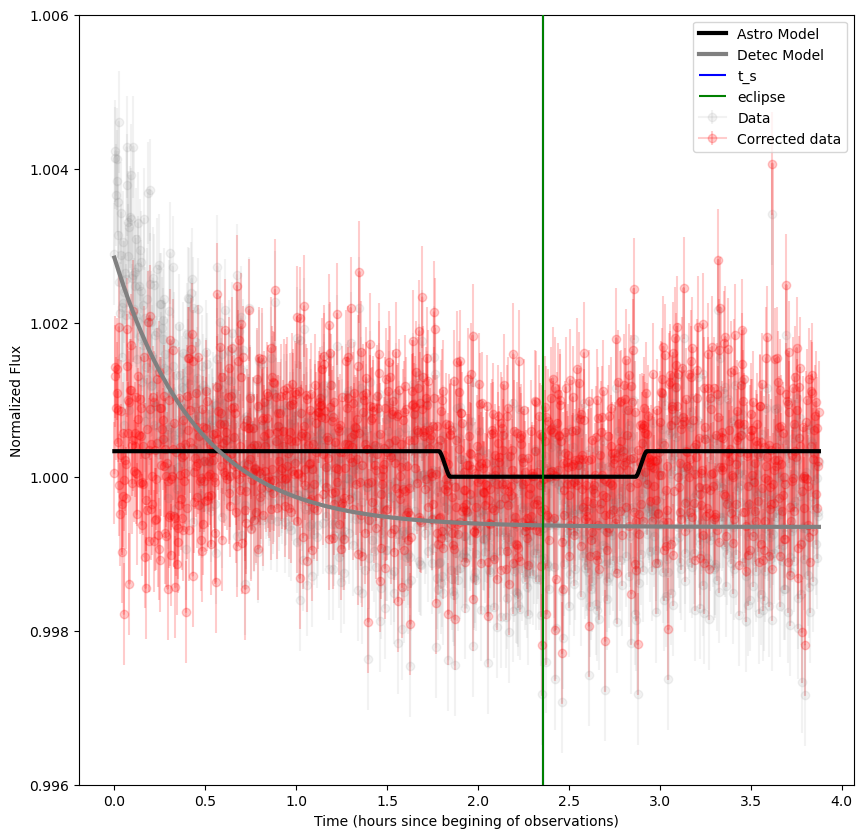

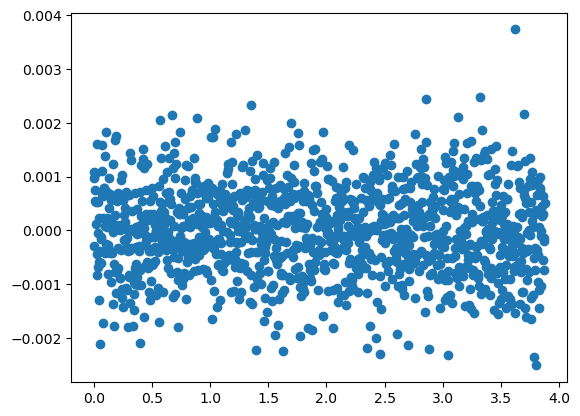

In [225]:
i=0
fig, ax = plt.subplots( 1, len(models), figsize=(10, 10))

fits = exponential_func((time), a, b, c)

for model in models:
    i=i+1
    t_s, fp, c1, c2, c3, sigF = p0_mcmc[model]
    astro = transit_model(time, t_s, fp)
    detec = detec_model(time, [t_s, fp, c1, c2, c3, sigF], model)
    plt.errorbar(time, aplev, yerr =aperr, label='Data', color='grey', alpha=0.1, marker='o', zorder=1)
    plt.errorbar(time,aplev/detec, yerr =aperr, label='Corrected data', color='red', alpha=0.2, marker='o', zorder=1)
    plt.plot(time, astro, label='Astro Model',color = 'black', zorder=2, linewidth=3)
    plt.plot(time, detec, label='Detec Model', color = 'grey', zorder=2, linewidth=3)
    plt.vlines(t_s, 0.994, 1.008, color='blue', label='t_s', zorder=3)
    plt.vlines(eclipse, 0.994, 1.008, color='green', label='eclipse', zorder=3)
    plt.ylim(0.996, 1.006)
    plt.legend()
    plt.xlabel('Time (hours since begining of observations)')
    plt.ylabel('Normalized Flux')

plt.figure()
residuals = (aplev/detec)-astro
plt.scatter(time,residuals)
print(np.std(residuals))
    

# fix th priors and eclipse duration in hours

    # calculate BIC
    #plot_bestfit(time, aplev/exponential_func(exp_time, a, b, c), astro, detec, showPlot=True, fontsize=20)

In [361]:
print((eclipse-t_s)*60)

0.001135703826462553


[60273.51641022 60273.51948844 60273.52256665 ... 60277.38572538
 60277.38880359 60277.39188181]


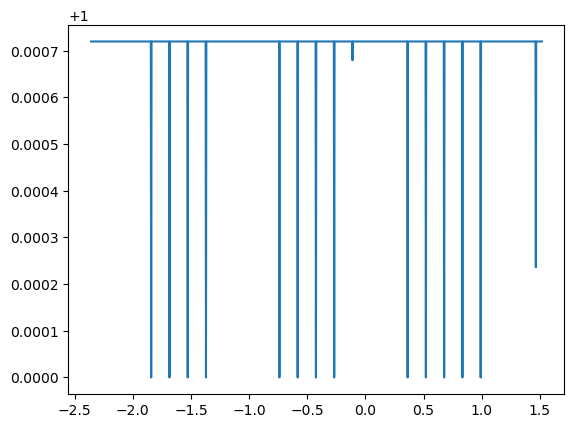

In [73]:
astro = transit_model(time, 0.0469, 0.00072)
plt.plot(time, astro, label='Astro Model')    

t_s, fp, c1, c2, c3, c4, c5, sigF = p0_mcmc[model]

# t_s = eclipse + (0.046954177958696/24)
print(time+eclipse)

# def transit_model(time, t_s, fp):
#     params = batman.TransitParams()       #object to store transit parameters
#     params.t0 = 58388.7939               #time of inferior conjunction
#     params.per = 3.777940                 #orbital period in hours
#     params.rp = 0.0539                   #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
#     params.a = 26.57                      #semi-major axis (in units of stellar radii)
#     params.inc = 89.8                     #orbital inclination (in degrees)
#     params.ecc = 0.                       #eccentricity
#     params.w = 90.                        #longitude of periastron (in degrees)
#     params.limb_dark = "quadratic"        #limb darkening model
#     params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
#     params.fp = fp                        #planet to star flux ratio
#     print(eclipse+(fp/24))
#     params.t_secondary = eclipse+(t_s/24)

#     m = batman.TransitModel(params, time, transittype="secondary")
#     flux = m.light_curve(params)
#     return flux

In [22]:
nbin = 500
ndiscard = 2 # removes ... mins

# remove more points to get the ramp out...
bins_time, binErr_t = binValues(time[ndiscard:], time[ndiscard:], nbin)
bins_aplev, binErr_aplev = binValues(aplev[ndiscard:], time[ndiscard:], nbin)
bins_aperr, binErr_aperr = binValues(aperr[ndiscard:], time[ndiscard:], nbin)
bins_centroid_x, binErr_centroid_x = binValues(centroid_x[ndiscard:], time[ndiscard:], nbin)
bins_centroid_y, binErr_centroid_y = binValues(centroid_y[ndiscard:], time[ndiscard:], nbin)

# unibnned
#ndiscard = 100
time = time[ndiscard:]
aplev = aplev[ndiscard:]
aperr = aperr[ndiscard:]
centroid_x = centroid_x[ndiscard:]
centroid_y = centroid_y[ndiscard:]

In [55]:
ndim = 9
samples = chain.reshape((-1, ndim))

MCMC_Results = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))

maxk, maxiter = np.unravel_index((lnprobchain).argmax(), (lnprobchain).shape)
p0_mcmc = chain[maxk, maxiter,:]
for i in range(len(p0_mcmc)):
    MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

p0_labels = ['t_s','fp', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'sigF']

out = "MCMC result:\n\n"
for i in range(len(p0_mcmc)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])
print(out, flush=True)

MCMC result:

     t_s = 60275.8720237047  +0.0023792973152012564  -0.0016579450239078142
      fp = 0.0002960993796929716  +5.286259020325295e-05  -5.320033321312394e-05
     c_1 = 13992.59268817908  +85184.55755634591  -83812.87523648371
     c_2 = -162.24197969360728  +889.1395223039043  -892.7290826525124
     c_3 = -59.036540790749655  +568.4052236570029  -577.1050892158222
     c_4 = 1.3680838280317122  +2.540688663224564  -2.5720237134115638
     c_5 = -1.463683731235447  +2.8030295780251784  -2.7462520252899134
     c_6 = 0.9705160998007669  +1.204324611038119  -1.2057320684294486
    sigF = 0.0008095795491855337  +1.650384465236819e-05  -1.5833784795611238e-05



In [152]:
np.abs(60275.870900424205-60275.875)*(24*60)
0.001*(24*60)

1.44

In [208]:
def walk_style(chain, labels, interv=10, fname=None, showPlot=False, fontsize=15):
    """Make a plot showing the evolution of the walkers throughout the emcee sampling.
    Args:
        chain (ndarray): The ndarray accessed by calling sampler.chain when using emcee
        labels (ndarray): The fancy labels for each dimension
        interv (int): Take every 'interv' element to thin out the plot
        name (string, optional): The savepath for the plot (or None if you want to return the figure instead).
        showPlot (bool, optional): Whether or not you want to show the plotted figure.
    Returns:
        None

    """

    nwalk = chain.shape[0]
    ndim = chain.shape[-1]

    # get first index
    beg   = 0
    end   = len(chain[0,:,0])
    step  = np.arange(beg,end)
    step  = step[::interv]

    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows

    # plotting
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        sig1 = (0.6827)/2.*100
        sig2 = (0.9545)/2.*100
        sig3 = (0.9973)/2.*100
        percentiles = [50-sig3, 50-sig2, 50-sig1, 50, 50+sig1, 50+sig2, 50+sig3]
        neg3sig, neg2sig, neg1sig, mu_param, pos1sig, pos2sig, pos3sig = np.percentile(chain[:,:,ind][:,beg:end:interv],
                                                                                       percentiles, axis=0)
        plt.plot(step, mu_param)
        plt.fill_between(step, pos3sig, neg3sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos2sig, neg2sig, facecolor='k', alpha = 0.1)
        plt.fill_between(step, pos1sig, neg1sig, facecolor='k', alpha = 0.1)
        plt.title(labels[ind], fontsize=fontsize)
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else:
            plt.xticks(rotation=25)

        y_formatter = ScalarFormatter(useOffset=False)
        plt.gca().yaxis.set_major_formatter(y_formatter)
        plt.gca().xaxis.set_tick_params(labelsize=fontsize*0.8)
        plt.gca().yaxis.set_tick_params(labelsize=fontsize*0.8)

    if fname != None:
        plt.savefig(fname, bbox_inches='tight')

    if showPlot:
        plt.show()

    #plt.close()
    return

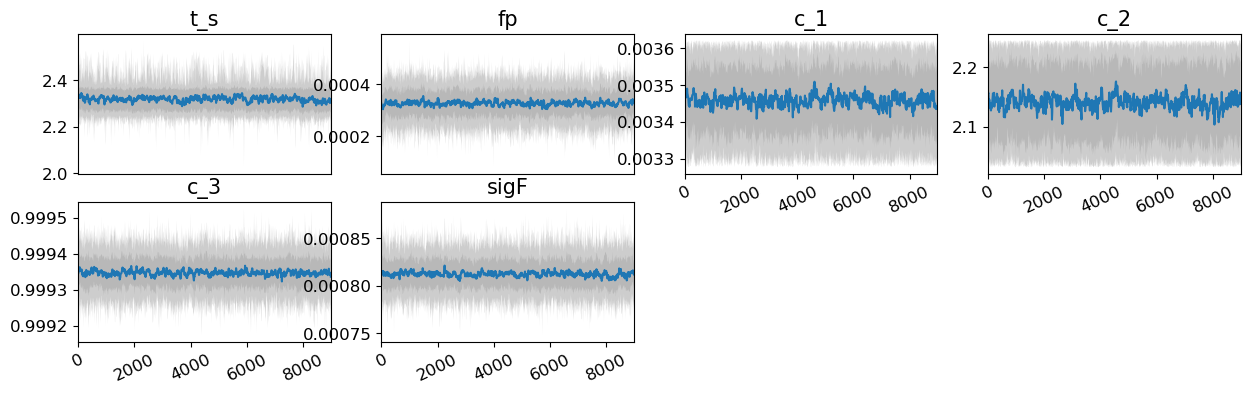

In [209]:
#walk_style(chain, p0_labels, interv=10, showPlot=True, fontsize=15)
walk_style(chain['exp'], p0_labels, interv=10, showPlot=True, fontsize=15)

In [57]:
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

labels = [r'$t_{s}$', r'$f_{p}$', r'$c_1$', r'$c_2$', r'$c_3$', r'$c_4$', r'$c_5$', r'$c_6$', r'$\sigma _F$']

samples = chain.reshape((-1, ndim))
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], labels = labels, show_titles=True,
                        plot_datapoints=False, label_kwargs={"fontsize": 24}, title_kwargs={"fontsize": 18}, quiet=False)

fig.savefig('MCMC_exp/corner_10000.png')
plt.close()

In [66]:
def plot_bestfit(time, flux, astro, detec, showPlot=True, fontsize=24):
    
    x = time
    
    fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(8, 14))
    
    axes[0].set_xlim(np.nanmin(x), np.nanmax(x))
    axes[0].plot(x, flux, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[0].plot(x, astro*detec, '.', color = 'r', markersize = 2.5, alpha = 0.4)
    axes[0].set_ylabel('Raw Flux', fontsize=fontsize)

    axes[1].plot(x, flux/detec, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[1].plot(x, astro, color = 'r', linewidth=2)
    axes[1].set_ylabel('Calibrated Flux', fontsize=fontsize)
    
    axes[2].axhline(y=1, color='k', linewidth = 2, linestyle='dashed', alpha = 0.5)
    axes[2].plot(x, flux/detec, '.', color = 'k', markersize = 4, alpha = 0.15)
    axes[2].plot(x, astro, color = 'red', linewidth=2)
    
    axes[2].axvline(x = 60275.875, color='r', linewidth = 2) #60275.875 e1
    axes[2].axvline(x = 60275.870900424205, color='g', linewidth = 2)

    axes[2].set_ylabel('Calibrated Flux', fontsize=fontsize)
    axes[2].set_ylim(ymin=1-3*np.nanstd(flux/detec - astro), ymax=np.max(astro)+3*np.nanstd(flux/detec - astro))

    axes[3].plot(x, flux/detec - astro, 'k.', markersize = 4, alpha = 0.15)
    axes[3].axhline(y=0, color='r', linewidth = 2)
    print(np.std(flux/detec - astro))


    axes[3].set_ylabel('Residuals', fontsize=fontsize)
    axes[3].set_xlabel('Time (BMJD)', fontsize=fontsize)

    
    fig.align_ylabels()
    fig.subplots_adjust(hspace=0)
    fig.savefig('MCMC_nogp_results/best_fit_10000.png')
        
    if showPlot:
        plt.show()
    
    plt.close()
    return

0.0008098558167310065


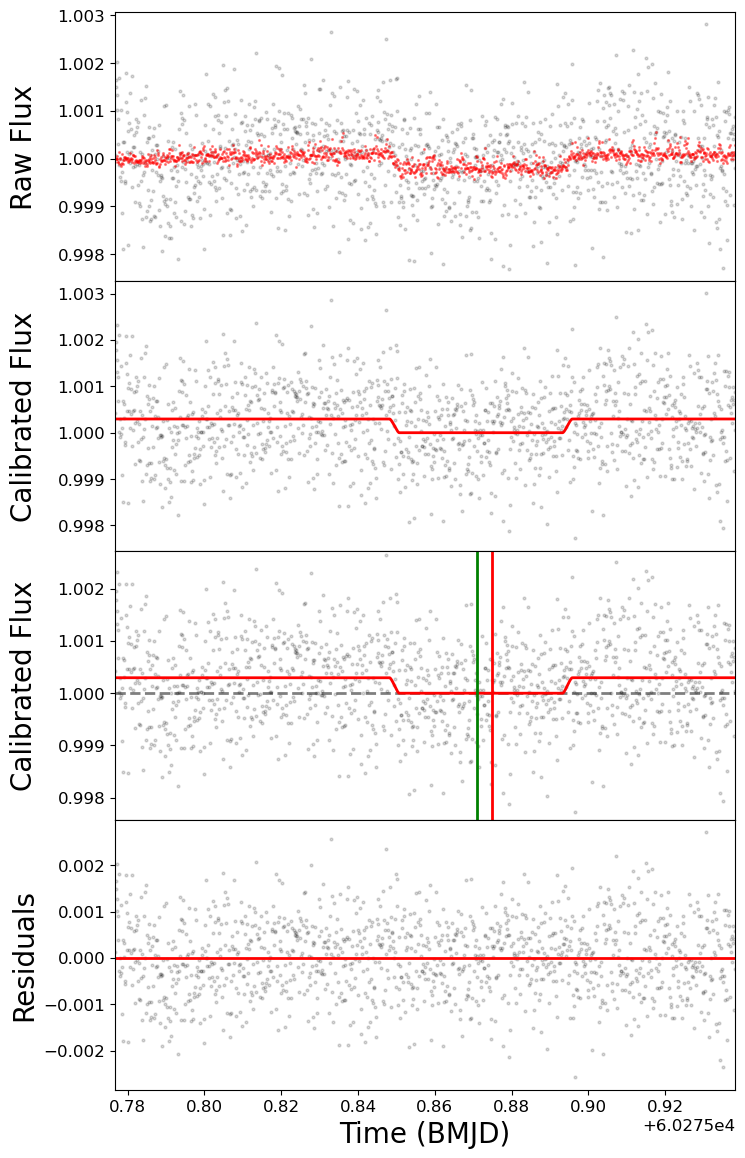

In [67]:
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
astro = transit_model(time, t_s, fp)
detec = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
plot_bestfit(time, aplev/exponential_func(exp_time, a, b, c), astro, detec, showPlot=True, fontsize=20)
#plot_bestfit(time, aplev, astro, detec, showPlot=True, fontsize=20)

In [73]:
# print(60275.8720237047-60275.875)
# print(np.abs(t_s - 60275.875)*(24*60))
#0.0023792973152012564
print((0.0029762952981400304)*(24*60))
print(0.0023792973152012564*(24*60))

4.285865229321644
3.4261881338898093


Text(0, 0.5, 'Normalized Flux')

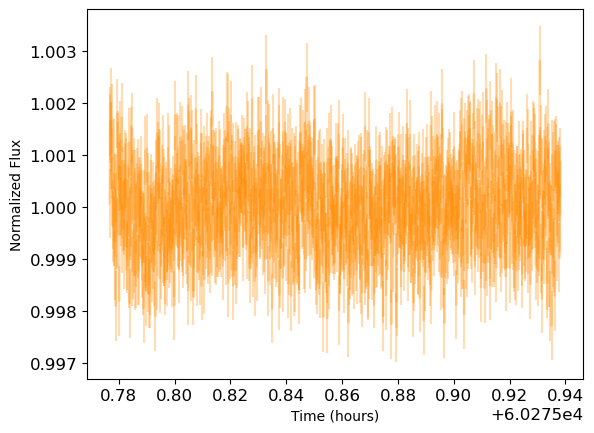

In [62]:
plt.figure()
plt.errorbar(time, aplev/exponential_func(exp_time, a, b, c), yerr=aperr, alpha=0.3, color='darkorange')
plt.xlabel('Time (hours)')
plt.ylabel('Normalized Flux')


In [115]:
def plot_rednoise(residuals, minbins, occDuration = None, showPlot=True, fontsize=10):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    plt.clf()
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS")
    ax.plot(binsz, stderr, c='darkorange', label="Gaussian std.")
    ylim = ax.get_ylim()
    # ax.plot([ingrDuration,ingrDuration],ylim, color='black', ls='--', alpha=0.6)
    if occDuration is not None:
        ax.plot([occDuration,occDuration],ylim, color='black', ls='-.', alpha=0.6)
    ax.set_ylim(ylim)
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    
    plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    plt.ylabel('RMS', fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    plt.savefig('MCMC_eclipse2/MCMC_RedNoise.png')

    if showPlot:
        plt.show()
    
    plt.close()

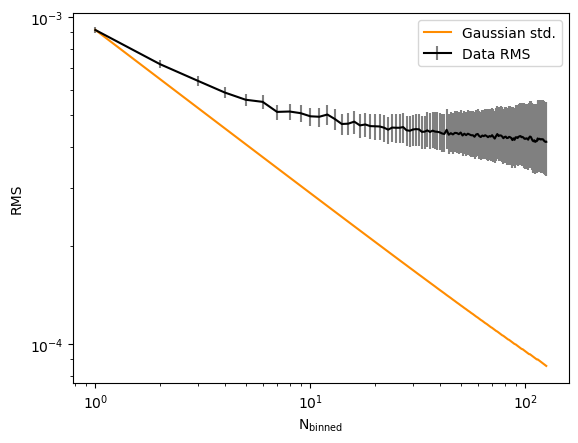

In [116]:
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
astro = transit_model(time, t_s, fp)
detec = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
residuals = ((aplev)/detec) - astro # /linear_slope(time, a, b )
plot_rednoise(residuals, 10)

In [299]:
np.std(residuals)/np.mean(aperr)

1.201837146957035

In [50]:
# BIC calculations
def BIC(n_dat, n_par, lnL):
    return n_par*np.log(n_dat) - 2*lnL  

# lnL is the likelihood value of best fit model, formula that depends on chi2, recheck

bic = BIC(len(time), len(p0_mcmc), lnprobchain.max())
print('BIC:', bic)

BIC: -12628.757705646785


In [51]:
# chi squared
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc

def chi_squared(time, flux, centroid_x, centroid_y, p0_mcmc):
    t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
    model = signal(time, centroid_x, centroid_y, t_s, fp, c1, c2, c3, c4, c5, c6)
    sigma2 = sigF**2
    return np.sum((flux - model) ** 2 / sigma2)

chi = chi_squared(time, aplev, centroid_x, centroid_y, p0_mcmc)
print(chi)

961.9305464132833


In [ ]:
# get polynomials first guess

# from binned data
start = eclipse - (e_dur / 2)  # Center the rectangle at the start of the eclipse

ind1 = np.abs(bins_time - start).argmin()
ind2 = np.abs(bins_time - (start + e_dur)).argmin()
print(ind1, ind2)
bins_time = np.delete(bins_time, np.arange(ind1,ind2))
bins_aplev = np.delete(bins_aplev, np.arange(ind1,ind2))
binErr_aplev = np.delete(binErr_aplev, np.arange(ind1,ind2))

params, covariance = curve_fit(poly_3rd_degree, bins_time, bins_aplev)
a, b, c, d = params
print(a, b, c, d)
# Generate the fitted curve using the parameters
fitted_curve = poly_3rd_degree(bins_time, a, b, c, d)
plt.errorbar(bins_time, bins_aplev, yerr=binErr_aplev[:-1], fmt='o', label='Data', color='black')
plt.plot(bins_time, fitted_curve, label='Fitted curve', color='blue', zorder=3)
